# 0. 环境与数据 / Environment and Data

## 0.1 说明 / Description

本 Notebook 在 Kaggle 平台运行。
- Notebook 链接：[https://www.kaggle.com/code/yiquanxiao/cosmetics-e-commerce-customer-segmentation-more](https://www.kaggle.com/code/yiquanxiao/cosmetics-e-commerce-customer-segmentation-more)
- 前作（EDA+异动分析）：[https://www.kaggle.com/code/yiquanxiao/cosmetics-e-commerce-eda-anomaly-analysis](https://www.kaggle.com/code/yiquanxiao/cosmetics-e-commerce-eda-anomaly-analysis)

---

This notebook runs on the Kaggle platform.
- Notebook Link: [https://www.kaggle.com/code/yiquanxiao/cosmetics-e-commerce-customer-segmentation-more](https://www.kaggle.com/code/yiquanxiao/cosmetics-e-commerce-customer-segmentation-more)
- Previous Work (EDA + Anomaly Detection): [https://www.kaggle.com/code/yiquanxiao/cosmetics-e-commerce-eda-anomaly-analysis](https://www.kaggle.com/code/yiquanxiao/cosmetics-e-commerce-eda-anomaly-analysis)

## 0.2 依赖 / Dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import joblib

# 1. 数据准备 / Data Preparation

## 1.1 读取与合并 / Load & Merge

In [2]:
# 1.1.1 批量读取 / Batch Load
# 指定数据目录（根据实际路径调整）/ Adjust the path if needed
data_path = Path("/kaggle/input/ecommerce-events-history-in-cosmetics-shop")

# 匹配 5 个 CSV 文件 / Match the five CSV files
csv_files = {
    "2019-10": "2019-Oct.csv", 
    "2019-11": "2019-Nov.csv", 
    "2019-12": "2019-Dec.csv", 
    "2020-01": "2020-Jan.csv", 
    "2020-02": "2020-Feb.csv"
}
files_path = {}
for key, name in csv_files.items():
    files_path[key] = data_path / name


# 统一列类型 / Standardize dtypes before reading
dtype_map = {
    "event_type": "category",
    "product_id": "int64",
    "category_id": "int64",
    "category_code": "string",
    "brand": "string",
    "price": "float64",
    "user_id": "int64", 
}

dfs = []
for key, fp in files_path.items():
    df = pd.read_csv(
        fp,
        dtype=dtype_map,
        parse_dates=["event_time"]   # 直接解析时间列 / parse datetime column
    )
    df["year_month"] = key      # 标注来源文件 / track source file
    dfs.append(df)


# 1.1.2 纵向合并 / Vertical Concatenation
df_raw = pd.concat(dfs, ignore_index=True)
print(f"合并后数据量 / Total rows after concat: {df_raw.shape[0]:,}")

合并后数据量 / Total rows after concat: 20,692,840


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20692840 entries, 0 to 20692839
Data columns (total 10 columns):
 #   Column         Dtype              
---  ------         -----              
 0   event_time     datetime64[ns, UTC]
 1   event_type     category           
 2   product_id     int64              
 3   category_id    int64              
 4   category_code  string             
 5   brand          string             
 6   price          float64            
 7   user_id        int64              
 8   user_session   object             
 9   year_month     object             
dtypes: category(1), datetime64[ns, UTC](1), float64(1), int64(3), object(2), string(2)
memory usage: 1.4+ GB


In [4]:
df_raw.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,year_month
0,2019-10-01 00:00:00+00:00,cart,5773203,1487580005134238553,<NA>,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10
1,2019-10-01 00:00:03+00:00,cart,5773353,1487580005134238553,<NA>,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10
2,2019-10-01 00:00:07+00:00,cart,5881589,2151191071051219817,<NA>,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10
3,2019-10-01 00:00:07+00:00,cart,5723490,1487580005134238553,<NA>,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10
4,2019-10-01 00:00:15+00:00,cart,5881449,1487580013522845895,<NA>,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10


## 1.2 数据清洗 / Data Cleaning

In [5]:
# === 1.2.1 重复值检查 / Duplicates ===========================================
dedup_keys = ["event_time", "user_id", "product_id", "event_type"]
before_dupes = df_raw.shape[0]
df_raw.drop_duplicates(subset=dedup_keys, keep="first", inplace=True)
print(f"删除重复行 / Duplicates removed: {before_dupes - df_raw.shape[0]:,}")

删除重复行 / Duplicates removed: 1,120,960


In [6]:
# === 1.2.2 缺失值处理 / Missing Values ======================================
# -----------------------------
# 1) 构建映射字典 / Build mapping dicts
# -----------------------------
def build_mode_mapping(df, key_col, value_col):
    """
    返回: {product_id: 最常出现的value}
    Return a dict: product_id -> most frequent value for that column.
    """
    tmp = (
        df.dropna(subset=[key_col, value_col])
          .groupby(key_col)[value_col]
          .agg(lambda x: x.mode().iloc[0])  # 取众数 / take mode
    )
    return tmp.to_dict()

prod2cat = build_mode_mapping(df_raw, "product_id", "category_code")
prod2brand = build_mode_mapping(df_raw, "product_id", "brand")


# -----------------------------
# 2) 回填缺失 / Fill missing using mapping
# -----------------------------
# category_code
mask_cat_na = df_raw["category_code"].isna() | (df_raw["category_code"] == "")
before_fill_cat = mask_cat_na.sum()
df_raw.loc[mask_cat_na, "category_code"] = (
    df_raw.loc[mask_cat_na, "product_id"].map(prod2cat)
)

after_fill_cat = df_raw["category_code"].isna().sum() + (df_raw["category_code"] == "").sum()
filled_cat = before_fill_cat - after_fill_cat
print(f"category_code: fill {filled_cat} missing values")

# brand
mask_brand_na = df_raw["brand"].isna() | (df_raw["brand"] == "")
before_fill_brand = mask_brand_na.sum()
df_raw.loc[mask_brand_na, "brand"] = (
    df_raw.loc[mask_brand_na, "product_id"].map(prod2brand)
)

after_fill_brand = df_raw["brand"].isna().sum() + (df_raw["brand"] == "").sum()
filled_brand = before_fill_brand - after_fill_brand
print(f"brand: fill {filled_cat} missing values")


# -----------------------------
# 3) 统一剩余缺失值 / Fill remaining NAs with fallback labels
# -----------------------------
df_raw["category_code"] = df_raw["category_code"].fillna("beauty_unknown")
df_raw["brand"] = df_raw["brand"].fillna("unknown_brand")

category_code: fill 1786 missing values
brand: fill 1786 missing values


[可选步骤] 移除时区信息 / [Optional Step] Remove timezone information (if present)

在电商数据分析中，我们通常按天、周、月聚合数据（如 GMV、留存率等）。时区对这些周期性统计结果影响很小，特别是当数据源已经标准化到 UTC 时。因此，为了简化后续操作，我们可以去掉时区信息。

In e-commerce data analysis, we usually aggregate data by day, week, or month (e.g., GMV, retention rates). Timezone differences have little impact on these metrics, especially if the data is already standardized to UTC. Therefore, we can safely remove the timezone information to simplify processing.

In [7]:
# Optional
df['event_time'] = df['event_time'].dt.tz_localize(None)

In [8]:
# === 1.2.3 时间解析 & 衍生列 / Time Parsing & Derived Columns ================
# event_date: 将时间截断到“天”，但保留 datetime64 dtype
# Normalize to midnight, keep dtype = datetime64[ns].
df_raw["event_date"] = df_raw["event_time"].dt.normalize()  
df_raw["event_month"] = df_raw["event_time"].dt.to_period("M")  
df_raw["event_weekday"] = df_raw["event_time"].dt.day_name()
df_raw["hour_bin"] = df_raw["event_time"].dt.hour // 4  # 6 个 4h 时段 / six 4‑h bins

/tmp/ipykernel_13/3471177408.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_raw["event_month"] = df_raw["event_time"].dt.to_period("M")


In [9]:
# === 1.2.4 行为编码 / Event Encoding ========================================
event_dummies = pd.get_dummies(df_raw["event_type"], prefix="is")
df_raw = pd.concat([df_raw, event_dummies], axis=1)

In [10]:
# === 1.2.5 清理无效价格 / Remove Invalid Prices ==============================
# 检查是否存在价格小于0的异常记录 / Check for abnormal records where price < 0
negative_prices = df_raw[df_raw['price'] < 0]
print(f"Number of negative price records: {len(negative_prices)}")

# 删除价格为负的记录，并重置索引 / Remove records with negative price values and reset the index
df_raw = df_raw[df_raw['price'] >= 0].reset_index(drop=True)

Number of negative price records: 124


In [11]:
df_raw.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,year_month,event_date,event_month,event_weekday,hour_bin,is_cart,is_purchase,is_remove_from_cart,is_view
0,2019-10-01 00:00:00+00:00,cart,5773203,1487580005134238553,beauty_unknown,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10,2019-10-01 00:00:00+00:00,2019-10,Tuesday,0,True,False,False,False
1,2019-10-01 00:00:03+00:00,cart,5773353,1487580005134238553,beauty_unknown,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10,2019-10-01 00:00:00+00:00,2019-10,Tuesday,0,True,False,False,False
2,2019-10-01 00:00:07+00:00,cart,5881589,2151191071051219817,beauty_unknown,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10,2019-10-01 00:00:00+00:00,2019-10,Tuesday,0,True,False,False,False
3,2019-10-01 00:00:07+00:00,cart,5723490,1487580005134238553,beauty_unknown,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10,2019-10-01 00:00:00+00:00,2019-10,Tuesday,0,True,False,False,False
4,2019-10-01 00:00:15+00:00,cart,5881449,1487580013522845895,beauty_unknown,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10,2019-10-01 00:00:00+00:00,2019-10,Tuesday,0,True,False,False,False


# 2. 用户价值分层 / Customer Segmentation

## 2.1 RFM & 行为特征工程 / RFM + Behavioural Features

In [12]:
# 仅保留购买事件用于 RFM / Keep purchases for RFM
purchase_df = df_raw[df_raw['is_purchase'] == 1]

# 参考日期 / Reference date for Recency calculation
ref_date = pd.Timestamp('2020-03-01', tz='UTC')

# --- 构建 RFM / Build RFM ---------------------------
rfm = purchase_df.groupby('user_id').agg(
    recency_days = ('event_time', lambda x: (ref_date - x.max()).days),
    frequency = ('event_time', 'count'),
    monetary = ('price', 'sum')
)

# --- 行为计数特征 / Behaviour count features --------
behaviour = df_raw.groupby('user_id').agg(
    view_cnt = ('is_view', 'sum'),
    cart_cnt = ('is_cart', 'sum'),
    remove_cnt = ('is_remove_from_cart', 'sum'),
    purchase_cnt = ('is_purchase', 'sum')
)

# 合并 / Combine
features = rfm.join(behaviour, how='outer').fillna(0)

# 日志缩放 + Min-Max / Log transform & Min-Max scaling
log_cols = ['recency_days','frequency','monetary','view_cnt','cart_cnt','remove_cnt','purchase_cnt']
features_log = features[log_cols].apply(lambda x: np.log1p(x))

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features_log)
features_scaled = pd.DataFrame(features_scaled, index=features.index, columns=log_cols)
features_scaled.head()

,recency_days,frequency,monetary,view_cnt,cart_cnt,remove_cnt,purchase_cnt
user_id,,,,,,,
465496,0.0,0.0,0.0,0.139645,0.0,0.0,0.0
1120748,0.0,0.0,0.0,0.069823,0.0,0.0,0.0
1180452,0.0,0.0,0.0,0.069823,0.0,0.0,0.0
1458813,0.0,0.0,0.0,0.349113,0.0,0.0,0.0
2038666,0.0,0.0,0.0,0.069823,0.0,0.0,0.0


## 2.2 K-means 聚类 / K-means Clustering

In [13]:
# # =============================================================================
# # 2.2.1 MiniBatchKMeans
# # =============================================================================
# inertia_list = []   # SSE / Inertia for Elbow
# # silhouette_list = []   # Silhouette scores
# model_dict = {}   # 保存各 k 的模型 / store models keyed by k

# k_range = range(3, 9)  # 尝试 3-8 个簇 / Try 3–8 clusters
# for k in tqdm(k_range, desc="MiniBatchKMeans"):
#     mbkm = MiniBatchKMeans(
#         n_clusters=k,
#         batch_size=16384,
#         max_iter=200,
#         n_init=10,
#         random_state=42,
#         verbose=0
#     )
#     mbkm.fit(features_scaled)
    
#     # 保存指标 / Save metrics
#     inertia_list.append(mbkm.inertia_)
#     # sil_score = silhouette_score(features_scaled, mbkm.labels_)
#     # silhouette_list.append(sil_score)
    
#     # 缓存模型 / Cache the trained model
#     model_dict[k] = mbkm

# print("All models trained & cached!")

In [14]:
# =============================================================================
# 2.2.1 KMeans
# =============================================================================
inertia_list = []   # SSE / Inertia for Elbow
# silhouette_list = []   # Silhouette scores
model_dict = {}   # 保存各 k 的模型 / store models keyed by k

k_range = range(3, 9)  # 尝试 3-8 个簇 / Try 3–8 clusters
for k in tqdm(k_range, desc="KMeans"):
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(features_scaled)
    
    # 保存指标 / Save metrics
    inertia_list.append(km.inertia_)
    # sil_score = silhouette_score(features_scaled, km.labels_)
    # silhouette_list.append(sil_score)
    
    # 缓存模型 / Cache the trained model
    model_dict[k] = km

print("All models trained & cached!")

KMeans: 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

All models trained & cached!


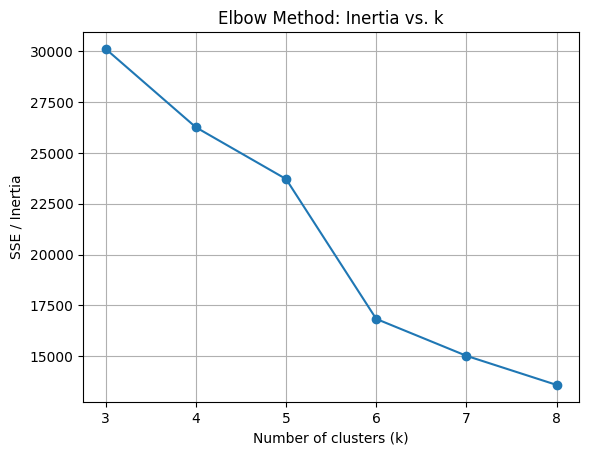

In [15]:
# 2.2.2 寻找最佳 K / Find Best K
# --- 绘制 Elbow 曲线 / Plotting Elbow Curve -----------------
plt.figure()
plt.plot(list(k_range), inertia_list, marker='o')
plt.title('Elbow Method: Inertia vs. k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE / Inertia')
plt.xticks(list(k_range))
plt.grid(True)
plt.show()

# # --- 绘制 Silhouette 分数 / Plotting Silhouette Scores -------
# plt.figure()
# plt.plot(list(k_range), silhouette_list, marker='o')
# plt.title('Silhouette Score vs. k')
# plt.xlabel('Number of clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.xticks(list(k_range))
# plt.grid(True)
# plt.show()

从 Elbow 曲线来看，K = 6 是最佳选择

---

Based on the Elbow curve, K = 6 is the optimal choice

In [16]:
# best_k = k_range[int(np.argmax(silhouette_list))]
# print(f"Best k by silhouette score: {best_k}")
best_k = 6

# 直接复用已缓存模型 / Retrieve the cached best model
final_km = model_dict[best_k]

# 将簇标签添加到特征表 / Attach cluster labels
features_scaled['cluster'] = final_km.labels_

# 保存簇标签至数据 / Map cluster back to df_raw
df_raw = df_raw.merge(
    features_scaled['cluster'],
    left_on='user_id',
    right_index=True,
    how='left'
)

In [17]:
# 2.2.3 保存 Scaler 和 KMeans 模型 / Save Scaler and KMeans Model
# 保存 StandardScaler 以便在线推断 / Save scaler for online inference
joblib.dump(scaler, '/kaggle/working/scaler.pkl')

# 保存 KMeans 聚类模型 / Save KMeans clustering model
joblib.dump(final_km, '/kaggle/working/kmeans_model.pkl')

# 保存成功提示 / Confirmation
print("Saved scaler.pkl, kmeans_model.pkl to disk.")

Saved scaler.pkl, kmeans_model.pkl to disk.


In [18]:
# 2.2.4 簇特征概览 / Cluster Feature Overview

# 1) 将簇标签合并回原始特征 / Attach cluster label to raw features
features_with_cluster = features.join(features_scaled['cluster'])

# 2) 计算簇规模 / Cluster size
cluster_size = features_with_cluster['cluster'].value_counts().rename('user_cnt')
cluster_pct  = (cluster_size / cluster_size.sum()).rename('user_pct')

# 3) 计算各特征的中位数 & 均值 / Median & Mean per feature
# agg_median = features_with_cluster.groupby('cluster')[log_cols].median().add_suffix('_median')
agg_mean   = features_with_cluster.groupby('cluster')[log_cols].mean().add_suffix('_mean')

# 4) 合并成画像表 / Combine into a profiling table
# cluster_profile = pd.concat([cluster_size, cluster_pct, agg_mean, agg_median], axis=1).sort_index()
# cluster_profile = pd.concat([cluster_size, cluster_pct, agg_median], axis=1).sort_index()
cluster_profile = pd.concat([cluster_size, cluster_pct, agg_mean], axis=1).sort_index()
cluster_profile.round(2)

,user_cnt,user_pct,recency_days_mean,frequency_mean,monetary_mean,view_cnt_mean,cart_cnt_mean,remove_cnt_mean,purchase_cnt_mean
cluster,,,,,,,,,
0,42326,0.03,59.77,23.18,102.66,80.46,66.34,42.00,23.18
1,1112742,0.68,0.00,0.00,0.00,1.37,0.04,0.01,0.00
2,160553,0.10,0.01,0.02,0.12,3.10,4.87,0.41,0.02
3,52816,0.03,0.02,0.07,0.36,29.42,27.16,17.57,0.07
4,204606,0.12,0.00,0.00,0.02,9.24,0.24,0.05,0.00
5,66315,0.04,78.01,4.49,29.53,11.78,8.09,2.92,4.49


# 3. 分层留存分析 / Segment-level Retention

In [19]:
# # 3.0 把 cluster 标签合并到主表 / Attach cluster to main DF
# all_features_scaled = pd.concat(
#     [features_scaled, features_test_scaled], axis=0
# )

# cluster_map = all_features_scaled["cluster"]

# df_raw = df_raw.merge(
#     cluster_map.rename("cluster"),
#     left_on="user_id",
#     right_index=True,
#     how="left",
# )

# print(
#     "Cluster label distribution (all data):\n",
#     df_raw["cluster"].value_counts(normalize=True).round(3),
# )

## 3.1 Cohort 构建 / Cohort Construction

In [20]:
# 仅保留购买事件 / Keep purchase events only
purchase = df_raw[df_raw['is_purchase'] == 1].copy()

# 计算首购月份 / First purchase month per user
first_purchase_month = purchase.groupby('user_id')['event_month'].min()

# 打标签 / Add cohort & purchase month
purchase['cohort_month']   = purchase['user_id'].map(first_purchase_month)
purchase['purchase_month'] = purchase['event_date'].dt.to_period('M')
# 计算距 cohort 的月份差 / Period index
purchase['period_index']   = (purchase['purchase_month'] - purchase['cohort_month']).apply(lambda x: x.n)

/tmp/ipykernel_13/1450132686.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  purchase['purchase_month'] = purchase['event_date'].dt.to_period('M')


## 3.2 留存热力图 / Retention Heatmap by Segment

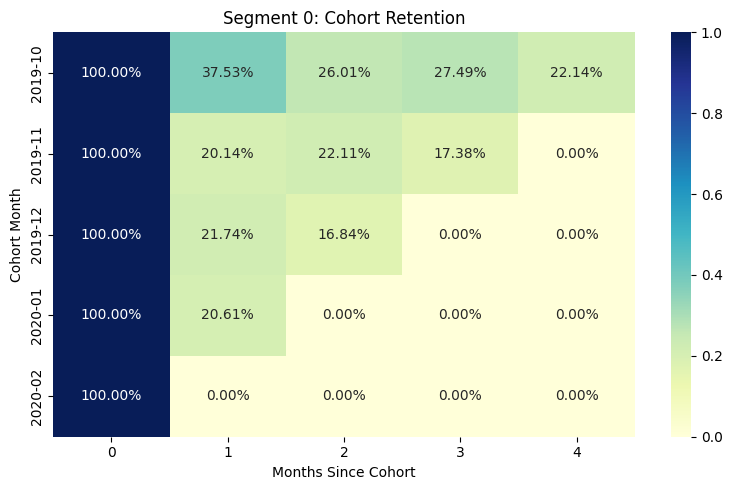

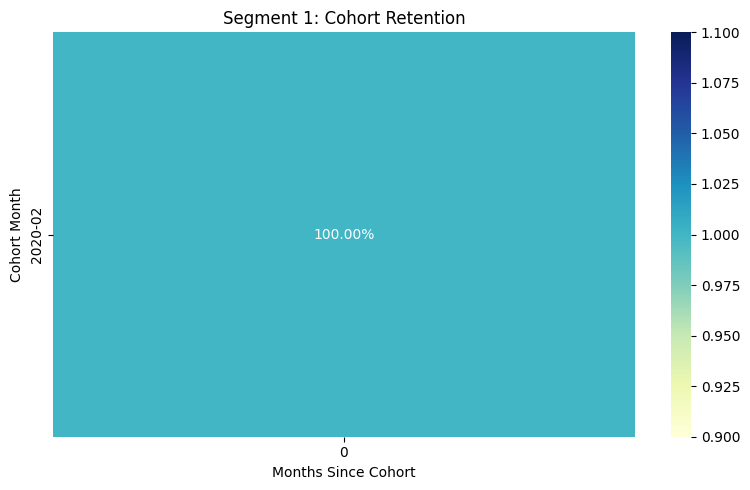

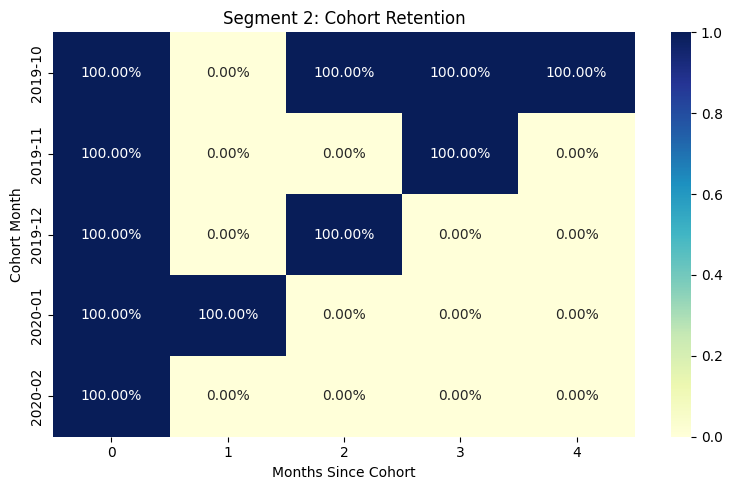

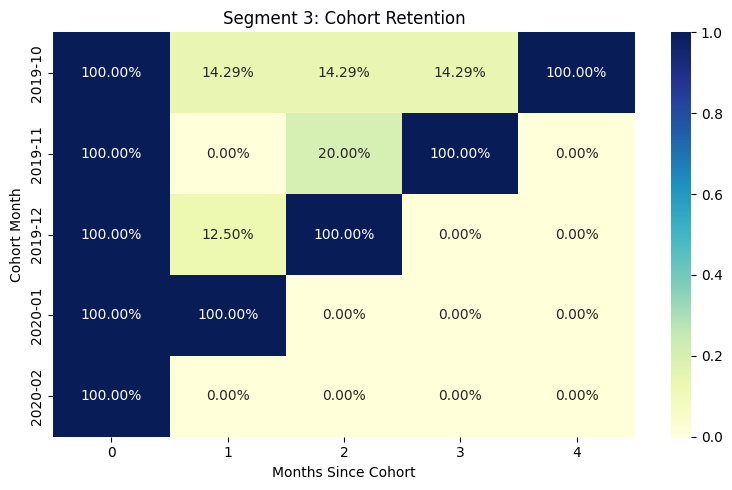

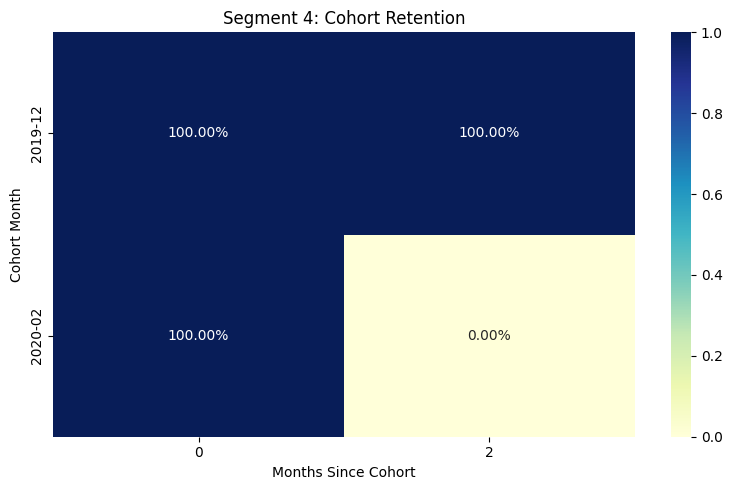

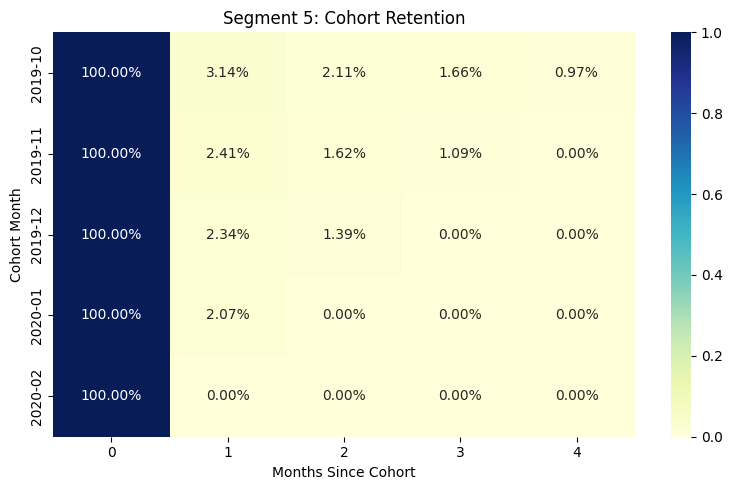

In [21]:
segments = sorted(purchase['cluster'].unique())

for seg in segments:
    seg_df = purchase[purchase['cluster'] == seg]
    
    # cohort matrix
    cohort_matrix = (
        seg_df.groupby(['cohort_month', 'period_index'])['user_id']
              .nunique()
              .unstack(fill_value=0)
    )
    cohort_sizes  = cohort_matrix.iloc[:, 0]
    retention     = cohort_matrix.divide(cohort_sizes, axis=0)
    
    # 绘图 / Plot
    plt.figure(figsize=(8, 5))
    sns.heatmap(
        retention,
        annot=True,
        fmt=".2%",
        cmap="YlGnBu",
        cbar=True
    )
    plt.title(f'Segment {seg}: Cohort Retention')
    plt.xlabel('Months Since Cohort')
    plt.ylabel('Cohort Month')
    plt.tight_layout()
    plt.show()

## 3.3 转化率漏斗 / Conversion Funnel

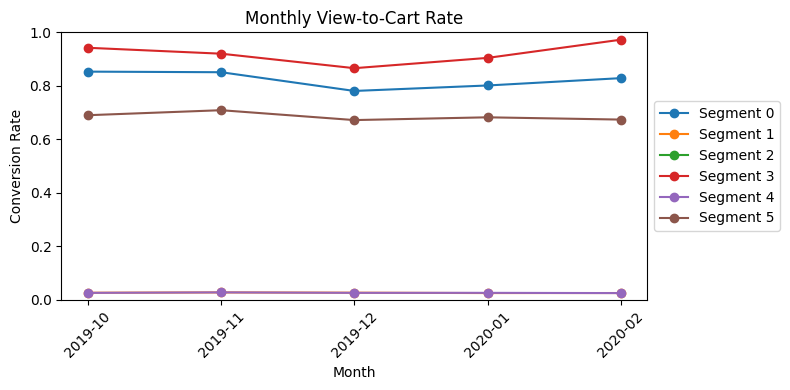

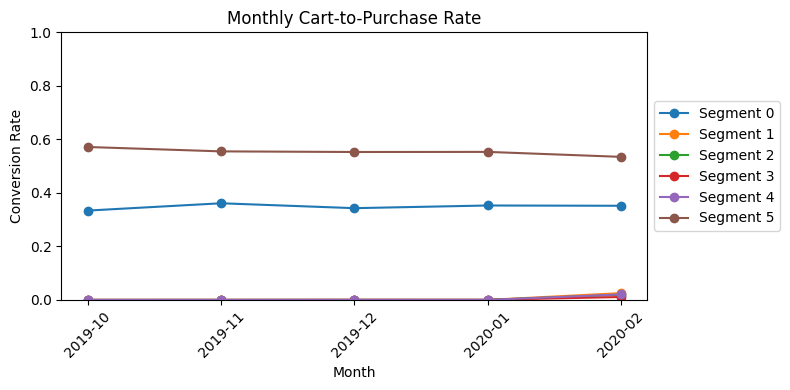

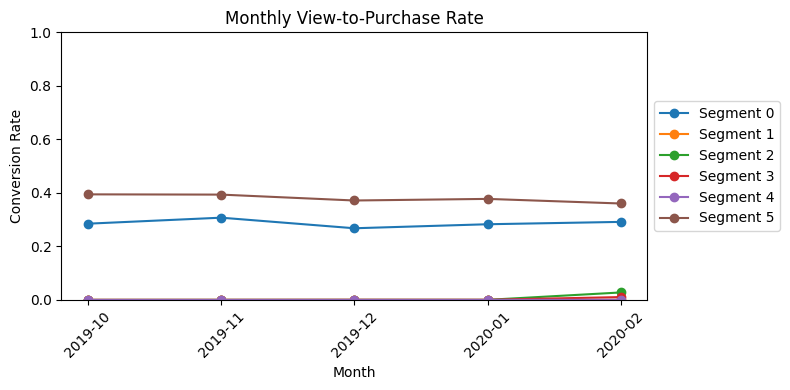

In [22]:
# 统计月度各阶段数量 / Monthly stage counts per cluster
stage_counts = (
    df_raw
    .groupby(['event_month', 'cluster'])
    .agg(
        view_cnt    = ('is_view',     'sum'),
        cart_cnt    = ('is_cart',     'sum'),
        purchase_cnt= ('is_purchase', 'sum')
    )
    .reset_index()
)

# 计算三种转化率，分母为 0 时结果设为 0
# Compute three types of conversion rates; set result to 0 if the denominator is 0
stage_counts['view_to_cart']     = np.where(
    stage_counts['view_cnt'] > 0,
    stage_counts['cart_cnt'] / stage_counts['view_cnt'],
    0.0
)

stage_counts['cart_to_purchase'] = np.where(
    stage_counts['cart_cnt'] > 0,
    stage_counts['purchase_cnt'] / stage_counts['cart_cnt'],
    0.0
)

stage_counts['view_to_purchase'] = np.where(
    stage_counts['view_cnt'] > 0,
    stage_counts['purchase_cnt'] / stage_counts['view_cnt'],
    0.0
)

# 每种转化率单独作图：多簇折线对比
# Plot each conversion rate separately: multi-cluster line comparison
rate_cols = {
    'view_to_cart'     : 'View-to-Cart Rate',
    'cart_to_purchase' : 'Cart-to-Purchase Rate',
    'view_to_purchase' : 'View-to-Purchase Rate'
}

for col, title in rate_cols.items():
    plt.figure(figsize=(8, 4))
    
    for seg in sorted(stage_counts['cluster'].unique()):
        seg_df = stage_counts[stage_counts['cluster'] == seg].copy()
        seg_df.sort_values('event_month', inplace=True)
        
        plt.plot(
            seg_df['event_month'].astype(str),
            seg_df[col],
            marker='o',
            label=f'Segment {seg}'
        )
    
    plt.title(f'Monthly {title}')
    plt.xlabel('Month')
    plt.ylabel('Conversion Rate')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.legend()
    plt.tight_layout()
    plt.show()

In [23]:
# 总转化率表 / Cluster-level Overall Conversion Table
# 1) 汇总所有月份的 stage 数量 / Aggregate stage counts over all months
overall_stage = (
    stage_counts.groupby('cluster')
    .agg(
        view_cnt     = ('view_cnt',     'sum'),
        cart_cnt     = ('cart_cnt',     'sum'),
        purchase_cnt = ('purchase_cnt', 'sum')
    )
)

# 2) 计算三类总转化率 / Compute overall rates (handle divide-by-zero)
overall_stage['view_to_cart_rate']     = np.where(
    overall_stage['view_cnt'] > 0,
    overall_stage['cart_cnt'] / overall_stage['view_cnt'],
    0.0
)
overall_stage['cart_to_purchase_rate'] = np.where(
    overall_stage['cart_cnt'] > 0,
    overall_stage['purchase_cnt'] / overall_stage['cart_cnt'],
    0.0
)
overall_stage['view_to_purchase_rate'] = np.where(
    overall_stage['view_cnt'] > 0,
    overall_stage['purchase_cnt'] / overall_stage['view_cnt'],
    0.0
)

# 3) 选取并格式化输出列 / Select & format for display
summary_cols = [
    'view_to_cart_rate',
    'cart_to_purchase_rate',
    'view_to_purchase_rate'
]
overall_conv_table = (
    overall_stage[summary_cols]
    .round(4)
    .reset_index()
)

# 4) 显示 DataFrame / Display the table
overall_conv_table

,cluster,view_to_cart_rate,cart_to_purchase_rate,view_to_purchase_rate
0,0,0.8246,0.3494,0.2881
1,1,0.0265,0.0052,0.0001
2,2,1.5691,0.0036,0.0056
3,3,0.9232,0.0026,0.0024
4,4,0.0265,0.0043,0.0001
5,5,0.6871,0.5547,0.3811


## 3.4 用户画像 / User Profiling

根据 [\[2.2.4 簇特征概览\]](#2.2-K-means-聚类-/-K-means-Clustering)，[\[总转化率表\]](#3.3-转化率漏斗-/-Conversion-Funnel)，以及[\[留存热力图\]](#3.2-留存热力图-/-Retention-Heatmap-by-Segment)，我们可以创建用户画像并进行对应的精细化运营。
> **注意**：留存热力图右下部分因时间未到而显示 0%；转化率 & 留存图包含了测试期用户预测的簇标签，可能与训练期簇特征有偏差。

---

Based on [\[2.2.4 Cluster Feature Overview\]](#2.2-K-means-Clustering), [\[Cluster-level Overall Conversion Table\]](#3.3-Conversion-Funnel), and [\[Retention Heatmap by Segment\]](#3.2-Retention-Heatmap-by-Segment), we can create user profiles and perform corresponding refined operations.

> **Note**: The bottom-right portion of the retention heatmap shows 0% because the corresponding time period has not yet occurred. Both the conversion and retention charts include predicted cluster labels for users in the test period, which may differ from the cluster features in the training period.

### 簇 0 / Cluster 0

**Cluster 0 用户画像**

* **核心价值群体**：占比仅 3% (42,326 人)，但拥有最高的用户消费力（中位 `frequency` ≈ 23, `monetary` ≈ 103）→ 平台的收入支柱。
* **高效决策者**：拥有极高的转化效率，`View→Cart ≈ 82.5%`，`Cart→Purchase ≈ 34.9%` → 购物目的性极强，是成熟的消费者。
* **近期流失风险**：中位 `recency` ≈ 60 天，是其最关键的风险特征 → 这批高价值用户正处于“休眠”状态。
* **历史忠诚度高**：留存分析显示其历史粘性非常强，次月复购率可达 20%-37% → 证明其对平台或品牌有深度认可。

---

**Cluster 0 精细化运营建议**

1.  **VIP专属召回计划**
    通过邮件(EDM)/短信(SMS)等渠道，推送“VIP专属回归礼券”或高价值无门槛优惠券，强调其尊贵身份，用高价值感召回用户。

2.  **个性化补货提醒**
    基于用户历史购买记录，智能计算其消耗周期，并发送“您常用的XXX快用完了吗？”之类的补货提醒，附上专属优惠，精准唤醒需求。

3.  **用户关怀与流失调研**
    发送“我们想念您”主题的关怀邮件，并附上一个简短的调研问卷（可用积分或小额优惠券作为激励），了解用户近期的流失原因，为后续策略优化提供依据。

---

**Cluster 0 User Profiling**

* **Core Value Segment**: Comprises only 3% of users (42,326) but boasts the highest purchasing power (median `frequency` ≈ 23, `monetary` ≈ 103) → The platform's revenue backbone.
* **Efficient Decision-Makers**: Exhibits outstanding conversion efficiency, with `View→Cart ≈ 82.5%` and `Cart→Purchase ≈ 34.9%` → Highly intentional and mature shoppers.
* **Recent Churn Risk**: Median `recency` of ≈ 60 days is their most critical risk factor → This high-value group is currently "hibernating."
* **Historically Loyal**: Retention analysis shows strong historical stickiness, with next-month repurchase rates ranging from 20% to 37% → Indicates a deep-seated trust in the platform or brand.

---

**Cluster 0 Targeted Strategies**

1.  **VIP-Exclusive Win-Back Program**
    Use channels like EDM/SMS to send "VIP Welcome Back" offers or high-value, no-threshold coupons, emphasizing their exclusive status to entice them back with a sense of high value.

2.  **Personalized Restock Reminders**
    Based on their purchase history, intelligently calculate their product consumption cycle and send reminders like, "Running low on your favorite XXX?" along with an exclusive discount to precisely reactivate their needs.

3.  **Customer Care & Churn Survey**
    Send a "We Miss You" themed email that includes a short survey (incentivized with points or a small coupon) to understand the reasons for their recent inactivity, providing valuable data for future strategic adjustments.

### 簇 1 / Cluster 1

**Cluster 1 用户画像**

* **绝对主力流量池**：占比高达 68% (1,112,742 人)，是构成平台用户基数的“路人”群体。
* **“一次性”浏览访客**：核心行为是“看一眼就走”，中位 `view_cnt` ≈ 1.4，而加购、购买等后续行为几乎为零。
* **几乎无转化意愿**：转化率极低，`View→Purchase` 仅有 0.01% → 他们是机会型访客，缺乏明确的购物需求。
* **忠诚度无法评估**：绝大多数用户无购买记录。极少数的购买者均集中在最后一个月，无法追踪其后续复购行为，因此整个群体可被视为无忠诚度。

---

**Cluster 1 精细化运营建议**

1.  **优化落地页与新客引导**
    针对这部分流量巨大但互动极低的用户，首要任务是优化他们首次触达的页面（Landing Page）。确保页面加载速度、突出卖点（如“全网销量第一”）、增加用户评价等社会认同信息，并设置清晰的新手引导或优惠券弹窗。

2.  **设置低门槛转化抓手**
    既然直接转化购买很难，目标应转为“留资”。通过设置“订阅邮件享9折优惠”、“参与肌肤测试领取小样”等低门槛互动，获取用户的联系方式（如邮箱），将其转化为可以进行后续营销的线索。

3.  **部署再营销策略**
    为网站布设再营销代码（如Meta Pixel, Google Ads Tag）。当这些用户访问后离开，可以在社交媒体或谷歌广告网络中，以较低的成本向他们重新展示他们浏览过的商品或相关的畅销品，以期在未来某个时点重新唤醒他们的兴趣。

---

**Cluster 1 User Profiling**

* **Absolute Main Traffic Pool**: Constitutes a massive 68% of users (1,112,742), representing the platform's broad "passer-by" base.
* **"One-Time" Browsing Visitors**: Their core behavior is "view and leave," with a median `view_cnt` of ≈ 1.4, while subsequent actions like adding to cart or purchasing are virtually zero.
* **Virtually No Conversion Intent**: Conversion rates are extremely low, with a `View→Purchase` rate of a mere 0.01% → They are opportunistic visitors lacking clear shopping goals.
* **Indeterminable Loyalty**: The vast majority have no purchase history. The tiny fraction of purchasers all appeared in the final month of the dataset, making it impossible to track repeat behavior. Thus, the segment as a whole is considered to have no loyalty.

---

**Cluster 1 Targeted Strategies**

1.  **Optimize Landing Page & New User Guidance**
    For this high-volume, low-engagement traffic, the priority is to optimize their first point of contact (the Landing Page). Ensure fast loading speeds, highlight key selling points (e.g., "No. 1 Best-Seller"), incorporate social proof like user reviews, and implement clear new-user guides or coupon pop-ups.

2.  **Implement Low-Barrier Conversion Hooks**
    Since direct conversion to purchase is difficult, the goal should shift to lead generation. Use low-barrier interactions like "Subscribe for 10% Off" or "Take the Skincare Quiz to Get a Free Sample" to capture user contact information (like emails), turning them into leads for future marketing.

3.  **Deploy Retargeting Strategies**
    Install retargeting pixels (e.g., Meta Pixel, Google Ads Tag) on the site. After these users visit and leave, you can re-engage them at a low cost on social media or the Google Display Network by showing ads for products they viewed or related best-sellers, aiming to re-spark their interest at a later time. 

### 簇 2 / Cluster 2

**Cluster 2 用户画像**

* **显著的“加购狂”**：占比 10% (160,553 人)，最怪异的特征是 `View→Cart` 转化率高达 157%，中位 `cart_cnt` (4.87) 显著高于 `view_cnt` (3.10) → 这表明他们频繁使用“快速加购”功能，或将同一商品多次加入购物车，可能是在用购物车进行比较或收藏。
* **极低的购买转化**：`Cart→Purchase` 转化率仅为 0.36%，几乎可以忽略不计 → 他们是典型的“加购即放弃”用户，购物车是他们行为的终点，而非起点。
* **“一次性”高兴趣访客**：用户行为非常近期 (`recency` ≈ 0)，但留存图显示后续月份几乎无任何复购 → 他们可能是被特定活动或商品吸引而来的冲动型访客，但兴趣消散极快。
* **高度不稳定性**：留存热力图完全不符合商业逻辑，这可能意味着该簇是算法产生的一个“边缘”或“混合”群体，其共性不如其他簇明显。

---

**Cluster 2 精细化运营建议**

1.  **引入“加入收藏”功能**
    这部分用户可能将购物车当成了“收藏夹”。在加购按钮旁增加一个明显的“加入收藏”或“Save for Later”按钮，将“高意向购买”和“暂时收藏”的行为分流。这既能优化用户体验，也能让营销团队获得更纯净的购物车数据。

2.  **优化购物车体验与费用透明化**
    用户在加购后迅速流失，可能是被未预见的费用（如运费、税费）“劝退”。在购物车页面或侧边栏**提前估算并展示总费用**，可以有效管理用户预期，减少进入结算流程后的放弃率。

3.  **部署智能“废弃购物车”挽回策略**
    针对这批海量“废弃购物车”的用户，建立自动化的挽回流程是关键。在用户加购后1-2小时，通过邮件或App Push发送提醒，内容可分三步：
    * **步骤一 (提醒)**：“您购物车里的宝贝还在等您哦！”
    * **步骤二 (制造稀缺感)**：“您心仪的商品库存不多了，快去看看吧！”
    * **步骤三 (轻度激励)**：“完成您的订单，即可享受专属小折扣。”

---

**Cluster 2 User Profiling**

* **The "Aggressive Carters"**: Comprising 10% of users (160,553), their most bizarre trait is a `View→Cart` conversion rate of 157%, with a median `cart_cnt` (4.87) notably higher than `view_cnt` (3.10) → This suggests frequent use of "quick add" features or adding the same item multiple times, possibly using the cart for comparison or as a wishlist.
* **Extremely Low Purchase Conversion**: The `Cart→Purchase` conversion rate is a negligible 0.36% → They are classic "add-and-abandon" users, for whom the shopping cart is the end of their journey, not the beginning.
* **"One-Off" High-Interest Visitors**: User activity is very recent (`recency` ≈ 0), but the retention chart shows almost no subsequent repurchasing → They are likely impulsive visitors drawn in by a specific event or product, but their interest fades extremely quickly.
* **Highly Unstable**: The retention heatmap defies business logic, which may imply this cluster is an "edge" or "mixed" group generated by the algorithm, with less distinct commonalities than other clusters.

---

**Cluster 2 Targeted Strategies**

1.  **Introduce a "Save to Wishlist" Feature**
    This segment may be using the shopping cart as a "wishlist." Add a prominent "Add to Wishlist" or "Save for Later" button next to the cart button to separate "high-intent" from "saving-for-later" behaviors. This improves user experience and provides the marketing team with cleaner cart data.

2.  **Optimize Cart Experience & Fee Transparency**
    The rapid drop-off after adding to cart could be due to unexpected costs (like shipping or taxes). **Proactively estimating and displaying the total cost** in the cart page or sidebar can effectively manage user expectations and reduce abandonment rates during the checkout process.

3.  **Deploy Smart Cart Abandonment Campaigns**
    For this massive volume of abandoned carts, an automated recovery flow is crucial. Trigger an email or push notification 1-2 hours after abandonment, following a three-step sequence:
    * **Step 1 (Reminder)**: "The items in your cart are waiting for you!"
    * **Step 2 (Create Scarcity)**: "Your favorite items are running low on stock, check them out now!"
    * **Step 3 (Light Incentive)**: "Complete your order to enjoy a small exclusive discount."

### 簇 3 / Cluster 3

**Cluster 3 用户画像**

* **高参与度的“研究员”**：占比 3% (52,816 人)，其最显著的特征是极高的浏览和购物车互动。中位 `view_cnt` ≈ 29，`cart_cnt` ≈ 27，`remove_cnt` ≈ 18 → 他们在网站上投入了大量时间，深度研究和挑选商品。
* **“加购-购买”断层严重**：`View→Cart` 转化率高达 92.3%，证明他们对商品有浓厚兴趣。然而，`Cart→Purchase` 转化率骤降至 0.26% → 临门一脚的转化是这个群体最大的痛点。
* **犹豫不决的行为特征**：高达 18 次的“移除购物车”中位次数是该群体的独特标签。→ 这表明他们反复权衡、对比，可能在价格、选择、或外部因素上极度犹豫。
* **缺乏忠诚度**：用户行为非常近期 (`recency` ≈ 0)，结合不稳定的留存数据来看，可以判断他们的深度逛览行为是单次的，并未转化为持续的复购习惯。

---

**Cluster 3 精细化运营建议**

1.  **推出“限时购物车”专属折扣**
    针对他们的犹豫不决，用“时间”作为催化剂。当系统检测到用户购物车内商品停留超过24小时，可自动触发一封邮件或App Push，提供一个“24小时内有效的9折优惠码”，通过制造稀缺感和紧迫感，促使其下定决心。

2.  **引入“对比清单”与“降价提醒”功能**
    既然他们是“研究员”，就为他们提供研究工具。允许用户将购物车内的商品一键加入“对比清单”，直观比较参数和价格。同时，在购物车内为商品增加“降价通知我”的按钮，将他们犹豫的行为转化为一次有效的用户授权和未来的营销触点。

3.  **强化社会认同与推荐**
    为了帮助他们克服“选择困难症”，在购物车页面对商品进行标签化引导。例如，为商品打上“热销爆款”、“95%用户好评”、“本周回购榜TOP1”等标签，利用他人的选择来给他们提供购买信心，降低决策成本。

---

**Cluster 3 User Profiling**

* **Highly-Engaged "Researchers"**: This 3% segment (52,816 users) is defined by extremely high browsing and cart interaction. Median `view_cnt` ≈ 29, `cart_cnt` ≈ 27, and `remove_cnt` ≈ 18 → They invest significant time on the site, deeply researching and curating products.
* **Severe Cart-to-Purchase Gap**: Their `View→Cart` conversion rate is an impressive 92.3%, indicating strong product interest. However, the `Cart→Purchase` rate plummets to just 0.26% → The final step of conversion is this group's biggest pain point.
* **Indecisive Behavior Pattern**: A median `remove_from_cart` count of ≈18 is this group's unique signature. → This shows they are repeatedly weighing options and comparing items, likely hesitating on price, choice, or other external factors.
* **Lack of Loyalty**: User activity is very recent (`recency` ≈ 0), and combined with the unstable retention data, it's clear their deep browsing is a one-off event that does not translate into a consistent repurchase habit.

---

**Cluster 3 Targeted Strategies**

1.  **Offer Time-Limited Cart Discounts**
    Counter their indecisiveness by using time as a catalyst. When the system detects items have been in a cart for over 24 hours, automatically trigger an email or push notification with a "10% off coupon, valid for 24 hours only." This creates scarcity and urgency to push them toward a decision.

2.  **Introduce Comparison & Price Drop Alert Features**
    If they are "researchers," give them research tools. Allow users to add cart items to a "Comparison List" for a side-by-side view of specs and prices. Additionally, add a "Notify me of price drops" button for cart items, converting their hesitation into a valuable user permission and a future marketing touchpoint.

3.  **Leverage Social Proof & Recommendations**
    To help them overcome "choice paralysis," use guiding labels within the shopping cart. Tag products with labels like "Best-Seller," "95% Positive Reviews," or "Top Repurchased Item of the Week." This use of social proof can build their confidence and lower their decision-making friction.

### 簇 4 / Cluster 4

**Cluster 4 用户画像**

* **有一定兴趣的浏览者**：占比 12% (204,606 人)，他们的核心特征是进行了中等程度的浏览（中位 `view_cnt` ≈ 9），但几乎没有其他互动 → 他们比“路人”用户更有好奇心，但兴趣尚未转化为行动。
* **“只看不加”的用户**：`View→Cart` 转化率仅 2.65%，后续购买转化率几乎为零 → 他们的浏览行为是发散的，缺乏明确的加购意向。
* **缺乏购买记录与忠诚度**：中位数购买数据为零，且留存图数据不可靠 → 表明这是一个由无购买行为的新访客或非活跃用户组成的群体，没有忠诚度可言。
* **数据不稳定性提醒**：该簇的留存热力图不符合正常模式，因此对该群体长期行为的任何判断都应非常谨慎。

---

**Cluster 4 精细化运营建议**

1.  **通过内容营销深化兴趣**
    既然用户愿意浏览近10个页面，说明他们对品类有兴趣。可以在商品详情页中嵌入“成分科普”、“使用教程”的博客文章或视频链接，或者提供“如何选择适合您的精华”之类的购买指南，将他们从单纯的“看商品”引导至“学知识”，从而建立品牌信任感。

2.  **利用互动工具主动引导**
    对于有浏览行为但无下一步动作的用户，可以用互动来破冰。例如，在网站设置“智能测肤”、“匹配你的专属色号”等趣味性测试(Quiz)，用户完成测试后直接推荐最适合的1-2款商品。这种方式比让用户自己在9个页面中选择，转化路径更短。

3.  **激励用户订阅邮件列表**
    这类用户是潜在的营销线索。可以设置当用户浏览超过5个页面后，触发一个“订阅我们的资讯，获取专业护肤技巧及首次购物9折优惠”的弹窗，将这些匿名的浏览者转化为可以长期沟通的邮件列表订阅者。

---

**Cluster 4 User Profiling**

* **Browsers with Latent Interest**: A 12% segment (204,606 users), their core characteristic is moderate browsing (median `view_cnt` ≈ 9) with almost no other interaction → They are more curious than "passer-by" users, but this interest has not yet converted into action.
* **The "Look, Don't Add" User**: The `View→Cart` conversion rate is only 2.65%, with subsequent purchase conversions being near-zero → Their browsing is exploratory and lacks clear intent to add items to the cart.
* **Lacking Purchase History & Loyalty**: Median purchase data is zero, and the retention chart is unreliable → This indicates a group of non-purchasing new visitors or inactive users with no established loyalty.
* **Data Instability Note**: This cluster's retention heatmap does not follow a normal pattern, so any judgment about its long-term behavior should be made with extreme caution.

---

**Cluster 4 Targeted Strategies**

1.  **Deepen Interest with Content Marketing**
    Since users are willing to view nearly 10 pages, they have an interest in the category. Embed links within product pages to "Ingredient Explained" blog posts, video tutorials, or buying guides like "How to Choose the Right Serum for You." This guides them from simply "viewing products" to "learning," which helps build brand trust.

2.  **Use Interactive Tools for Proactive Guidance**
    For users who browse but don't take the next step, use interaction to break the ice. For example, implement fun quizzes on the site like "Smart Skin Analysis" or "Find Your Perfect Shade." After completion, recommend 1-2 highly suitable products directly. This provides a much shorter conversion path than letting them choose from 9 different pages.

3.  **Incentivize Newsletter Subscription**
    These users are potential marketing leads. Configure a pop-up to trigger after a user has viewed more than 5 pages, offering "Subscribe to our newsletter for pro skincare tips and 10% off your first order." This converts anonymous browsers into long-term, communicable leads. 

### 簇 5 / Cluster 5

**Cluster 5 用户画像**

* **高效转化的潜力股**：占比 4% (66,315 人)，拥有平台中最高的转化率：`Cart→Purchase` 高达 55.5%，`View→Purchase` 达到 38.1% → 一旦他们决定购物，决策就极为果断，几乎没有犹豫。
* **中度价值贡献者**：具备一定的重复购买历史（中位 `frequency` ≈ 4.5），消费金额适中 → 他们是平台的的价值客户，而非“一锤子买卖”。
* **严重流失状态**：最危险的信号是其高达 78 天的 `recency` 中位数 → 这意味着这批高效的消费者平均已超过两个半月没有回归。
* **忠诚度偏低**：留存热力图符合逻辑，但也显示出他们的次月留存率仅在 2-3% 左右徘徊 → 他们很容易流失，并未在平台形成稳固的购物习惯。

---

**Cluster 5 精细化运营建议**

1.  **实施“直达主题”式召回**
    对于这群决策果断的用户，营销信息应避免花哨，直击要点。通过邮件/短信发送简单直接、吸引力强的优惠，例如“【限时回归】全场免运费”或“您有一张20% OFF优惠券待查收”，最大程度降低他们的决策成本，促使其“高效”回归。

2.  **试行“补货提醒”与“定期购”**
    他们可能是需求驱动型消费者（用完了才买）。可以基于其历史订单（如购买了消耗品），在预估的消耗周期末（如第60-75天）发送“您常用的XXX需要补货了吗？”的提醒。同时，对他们购买过的消耗品推出“定期购享折扣”功能，将他们单次的“高效转化”变为持续的“忠诚锁定”。

3.  **发起流失原因调研**
    这群用户在站内的转化毫无障碍，但就是不再回来，原因很可能出在“购买后”的体验（如物流、商品、售后）。可以针对性地发送一份简短的调研问卷，附上小额奖励，询问他们上次购物体验如何，以及不再光顾的原因，从而发现运营或服务中的盲点。

---

**Cluster 5 User Profiling**

* **High-Efficiency Potential Customers**: A 4% segment (66,315 users) boasting the platform's highest conversion rates: `Cart→Purchase` is an outstanding 55.5%, and `View→Purchase` is 38.1% → Once they decide to buy, they are extremely decisive and rarely hesitate.
* **Moderate Value Contributors**: They have a history of repeat purchases (median `frequency` ≈ 4.5) with moderate spending → They are valuable, established customers, not just one-time buyers.
* **Seriously Lapsed State**: Their most critical risk signal is a high median `recency` of ≈ 78 days → This means these efficient shoppers have been inactive for over 2.5 months on average.
* **Low Loyalty**: The cohort retention chart, while logical, shows that their next-month retention hovers at a low 2-3% → They churn easily and have not formed a stable shopping habit on the platform.

---

**Cluster 5 Targeted Strategies**

1.  **Implement a "To-the-Point" Win-Back Strategy**
    For this decisive group, marketing messages should be direct and skip the fluff. Send simple, strong offers via email/SMS, such as "[Limited-Time Return Offer] Free Shipping on All Orders" or "You Have a 20% OFF Coupon Waiting." This minimizes their decision-making friction and encourages an "efficient" return.

2.  **Pilot "Restock Reminders" & "Subscribe & Save"**
    They may be need-based consumers who only buy when they run out of a product. Based on their order history (especially for consumables), send a "Time to restock your XXX?" reminder around the estimated end of the product's lifecycle (e.g., day 60-75). Additionally, introduce a "Subscribe & Save" feature for these items to convert their one-off efficient purchases into locked-in loyalty.

3.  **Launch a Churn Reason Survey**
    These users convert seamlessly on-site but don't return, suggesting the problem may lie in the post-purchase experience (e.g., shipping, product quality, customer service). Target them with a short survey, incentivized with a small reward, asking about their last experience and reasons for not returning. This can help uncover blind spots in operations or service.